# Frage 3
---

Gibt es einen Zusammenhang zwischen dem Trinkgeldverhalten und der Tageszeit, dem 
Wochentag, oder dem Zeitabstand zur vorhergehenden Bestellung?

In [1]:
import os
import sys
import pandas as pd 
from sqlalchemy import func, Integer
import scipy.stats as stats
import matplotlib.pyplot as plt



notebook_dir = os.getcwd()  
module_path = os.path.abspath(os.path.join(notebook_dir, '..'))  
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.db import get_engine, get_session
from custom_types.db_models import Order, Product, Einkaufskorb, Department, Aisle

engine = get_engine(path = "sqlite:///../../DABI1.db")
session = get_session(engine)


Verbindung erfolgreich


In [2]:
from IPython.display import Markdown

In [3]:
from sqlalchemy import case, func


result_dow = session.query(
    Order.day_of_the_week,
    func.count().label('total_orders'),  # Gesamtzahl der Bestellungen
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  # Anzahl der Bestellungen mit Trinkgeld (True = 1, False = 0)
).group_by(Order.day_of_the_week).all()

result_dow_tips = session.query(
    Order.day_of_the_week,
    func.sum(case((Order.tips == True, 1), else_=0)).label('tips_given'),  # Anzahl Bestellungen mit Trinkgeld
    func.sum(case((Order.tips == False, 1), else_=0)).label('no_tips')    # Anzahl Bestellungen ohne Trinkgeld
).group_by(Order.day_of_the_week).all()

/tmp/ipykernel_9155/3634030466.py:8: SAWarning: relationship 'Order.einkaufskorb' will copy column orders.order_id to column einkaufskorb.order_id, which conflicts with relationship(s): 'Order.products' (copies orders.order_id to einkaufskorb.order_id), 'Product.orders' (copies orders.order_id to einkaufskorb.order_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="orders,products"' to the 'Order.einkaufskorb' relationship. (Background on this warning at: https://sqlalche.me/e/20/qzyx) (This warning originated from the `configure_mappers()` process, which was invoked automatically in response to a user-initiated operation.)
  ).g

---
### Zusammenhang zwischen Trinkgeldverhalten und Wochentag

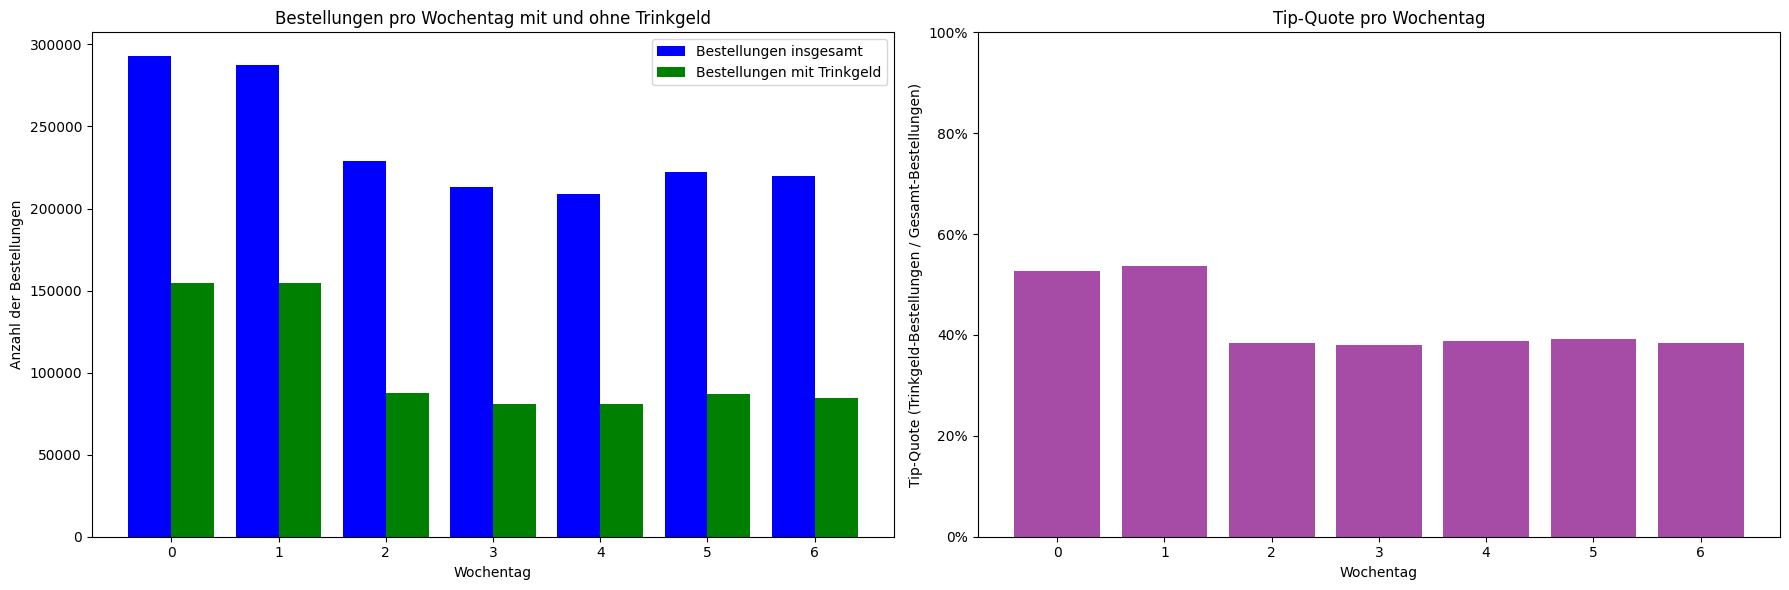

In [4]:
import matplotlib.pyplot as plt

# Daten vorbereiten
days = [row.day_of_the_week for row in result_dow]
total_orders = [row.total_orders for row in result_dow]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_dow]
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result_dow]

# Subplot erstellen: 1 Zeile, 2 Spalten
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # Breite von 18 für nebeneinander

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
width = 0.4
x = range(len(days))

# Hinzufügen der Balken
ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='blue')
ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', color='green')

# Beschriftung der Achsen
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Wochentag mit und ohne Trinkgeld')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(days)

# Legende hinzufügen
ax1.legend()

# Diagramm 2: Tip-Quote
ax2.bar(days, tip_ratios, color='purple', alpha=0.7)

# Beschriftung der Achsen
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Tip-Quote (Trinkgeld-Bestellungen / Gesamt-Bestellungen)')
ax2.set_title('Tip-Quote pro Wochentag')

# Prozentuale Formatierung der Y-Achse
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# X-Achsen-Beschriftung und Layout
ax2.set_xticks(days)
ax2.set_xticklabels(days)

# Layout und Anzeige
plt.tight_layout()  # Optimale Platznutzung
plt.show()


In [5]:
from scipy.stats import chi2_contingency
import pandas as pd
from tabulate import tabulate

# Ergebnisse der Query in ein DataFrame umwandeln
data = [
    {'day_of_the_week': row[0], 'tips_given': row[1], 'no_tips': row[2]}
    for row in result_dow_tips
]
df = pd.DataFrame(data)

# Kontingenztabelle erstellen
contingency_table = df.set_index('day_of_the_week')[['tips_given', 'no_tips']]


In [6]:
contingency_table

,tips_given,no_tips
day_of_the_week,,
0,154438,138307
1,154377,133199
2,87705,141113
3,81110,132305
4,81036,127579
5,87211,134991
6,84236,135414


In [7]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = contingency_table.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
table_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(table_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
table_results = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(table_results))



Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                     154438 |                 127755   |                  138307 |                164990 |
|           1 |                     154377 |                 125499   |                  133199 |                162077 |
|           2 |                      87705 |                  99857.1 |                  141113 |                128961 |
|           3 |                      81110 |                  93135.2 |                  132305 |                120280 |
|           4 |                      81036 |                  91040.4 |                  127579 |                117575 |
|           5 |                      87211 |                  96969.8 |                  134991 |                125232 |
|           6 |                      84236 |                  95856.1 |                  135414 |                123794 |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 33249.758 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 6         |
| Signifikanz           | Ja        |

Dass Wochentag und Trinkgeldverhalten unabhängig voneinander sind kann ausgeschlossen werden, Da die Hypothese der Unabhängigkeit zwischen Trinkgeldverhalten und Wochentag des Chi²-Tests mit starker signifikanz verworfen werden kann.

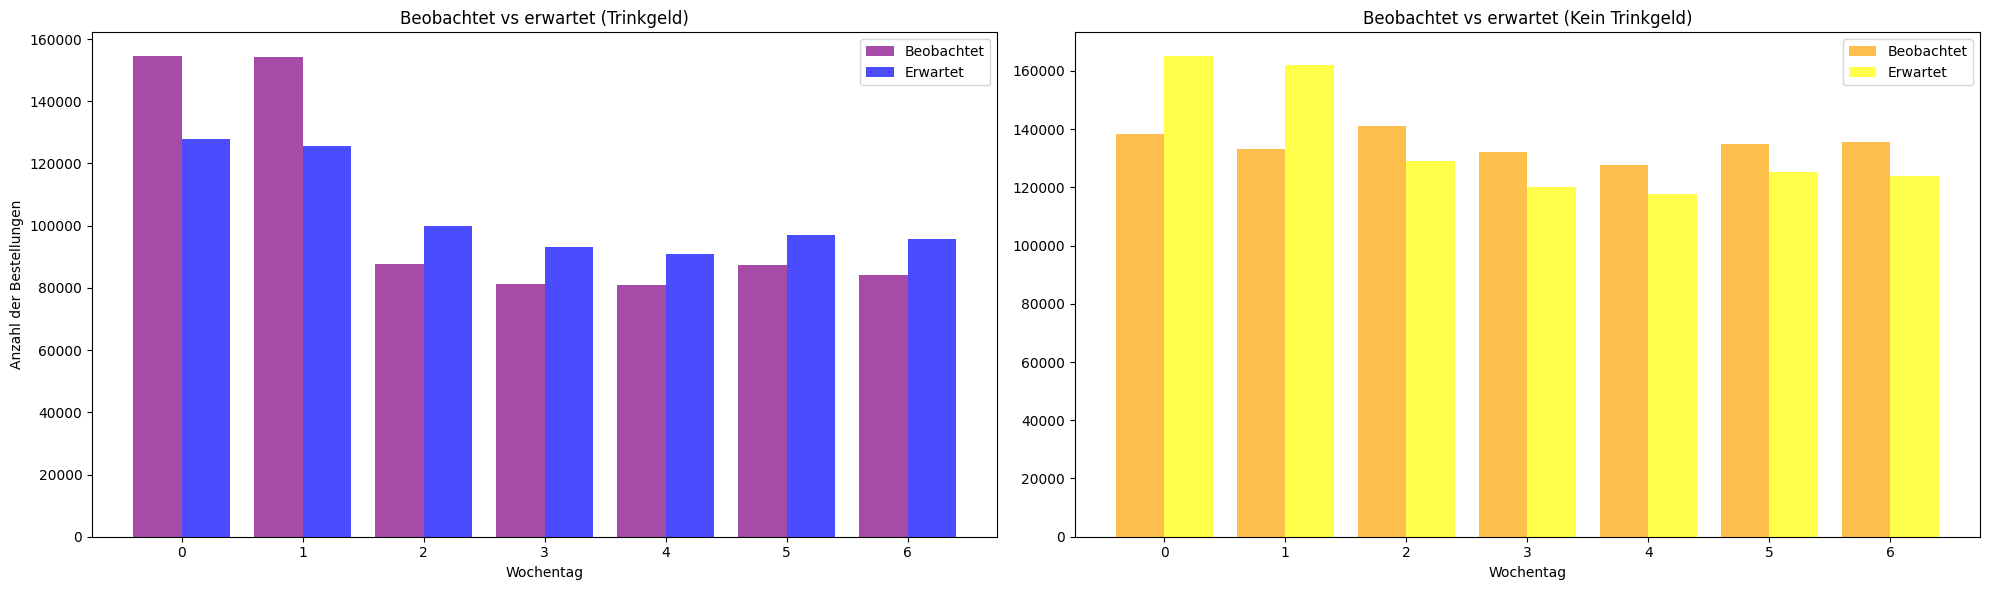

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Daten vorbereiten
observed = contingency_table.values  # Beobachtete Werte
days = contingency_table.index       # Wochentage
expected = expected                  # Erwartete Werte

# Balkenbreite und Positionen
bar_width = 0.4
x = np.arange(len(days))  # X-Positionen für Wochentage

# Subplots erstellen
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 Zeile, 2 Spalten

# Plot 1: Trinkgeld
axes[0].bar(x - bar_width / 2, observed[:, 0], bar_width, label="Beobachtet", color="purple", alpha=0.7)
axes[0].bar(x + bar_width / 2, expected[:, 0], bar_width, label="Erwartet", color="blue", alpha=0.7)
axes[0].set_title("Beobachtet vs erwartet (Trinkgeld)")
axes[0].set_xlabel("Wochentag")
axes[0].set_ylabel("Anzahl der Bestellungen")
axes[0].set_xticks(x)
axes[0].set_xticklabels(days)
axes[0].legend()

# Plot 2: Kein Trinkgeld
axes[1].bar(x - bar_width / 2, observed[:, 1], bar_width, label="Beobachtet", color="orange", alpha=0.7)
axes[1].bar(x + bar_width / 2, expected[:, 1], bar_width, label="Erwartet", color="yellow", alpha=0.7)
axes[1].set_title("Beobachtet vs erwartet (Kein Trinkgeld)")
axes[1].set_xlabel("Wochentag")
axes[1].set_xticks(x)
axes[1].set_xticklabels(days)
axes[1].legend()

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


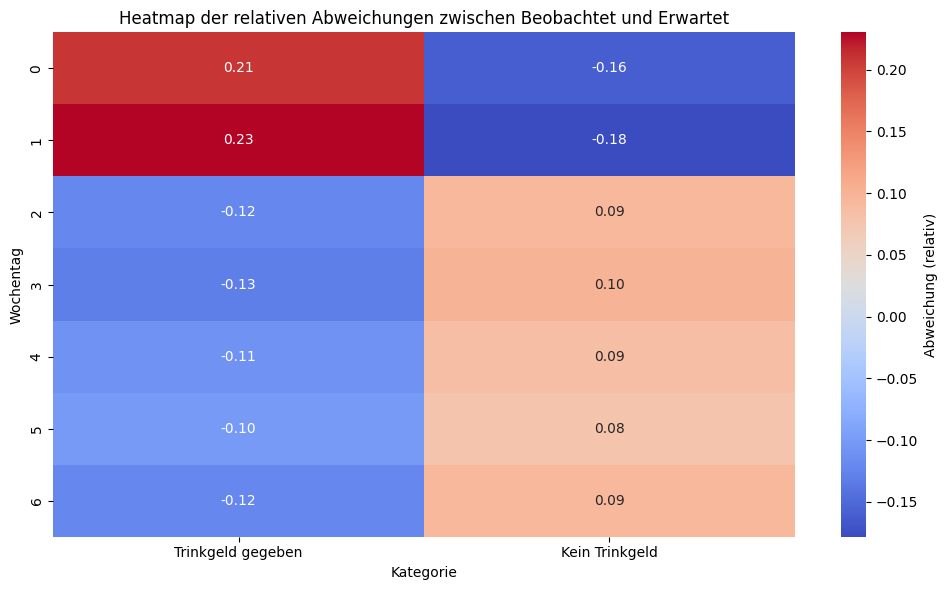

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Daten vorbereiten
observed = contingency_table.values  # Beobachtete Werte
expected = expected                  # Erwartete Werte
days = contingency_table.index       # Wochentage

# Abweichungen berechnen (relativ oder absolut)
deviation = (observed - expected) / expected  # Relative Abweichung (Prozentsatz)
# deviation = observed - expected  # Absolute Abweichung

# DataFrame für Heatmap erstellen
heatmap_data = pd.DataFrame(deviation, columns=["Trinkgeld gegeben", "Kein Trinkgeld"], index=days)

# Heatmap zeichnen
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Abweichung (relativ)'})
plt.title("Heatmap der relativen Abweichungen zwischen Beobachtet und Erwartet")
plt.xlabel("Kategorie")
plt.ylabel("Wochentag")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd


# Daten aus der Order-Tabelle extrahieren
result = session.query(
    Order.day_of_the_week,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

df = pd.DataFrame(result, columns=['day_of_week', 'tips_given'])


In [11]:
# logistische Regression
# One-Hot-Encoding für 'day_of_week' (von numerischen Werten zu binären Spalten)
df_encoded = pd.get_dummies(df, columns=['day_of_week'], prefix='day')

# Feature und Zielvariable
X = df_encoded.drop('tips_given', axis=1)  
y = df_encoded['tips_given']               

X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model_day = LogisticRegression(max_iter=1000)  # max_iter erhöhen, wenn Konvergenzprobleme auftreten

model_day.fit(X_train_day, y_train_day)

y_pred = model_day.predict(X_test_day)

accuracy = accuracy_score(y_test_day, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

coefficients = model_day.coef_.flatten()
intercept = model_day.intercept_[0]

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
coeff_df = pd.DataFrame({
    'Day of Week': days_of_week,
    'Coefficient': coefficients
})

print("Intercept:", intercept)
display(coeff_df)

Accuracy: 58.62%
Intercept: -0.2588961467056162


,Day of Week,Coefficient
0,Monday,0.366213
1,Tuesday,0.408174
2,Wednesday,-0.217128
3,Thursday,-0.232649
4,Friday,-0.194186
5,Saturday,-0.176958
6,Sunday,-0.212348


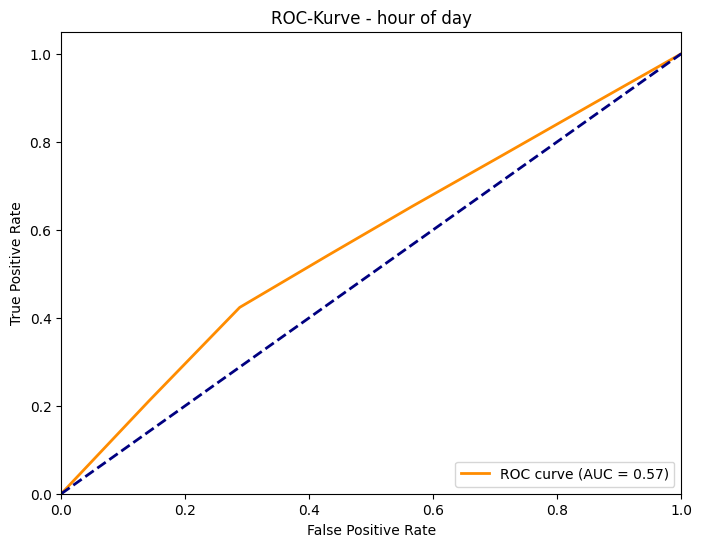

In [12]:
from sklearn.metrics import roc_curve, auc

# Berechnung der Vorhersagewahrscheinlichkeiten
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_test_day, y_prob_day)

# Berechnung der AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale Linie (Zufallsklassifikator)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve - hour of day')
plt.legend(loc='lower right')
plt.show()


-> Alleine der Wochentag reicht nicht aus um das Trinkgeldverhalten gut zu modellieren. Es gibt noch weitere Einflussfaktoren

---
### Zusammenhang zwischen Trinkgeldverhalten und Tageszeit

In [13]:
from sqlalchemy import case, func


result_hours = session.query(
    Order.hour_of_day,
    func.count().label('total_orders'),  # Gesamtzahl der Bestellungen
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  # Anzahl der Bestellungen mit Trinkgeld (True = 1, False = 0)
).group_by(Order.hour_of_day).all()

result_hours_tips = session.query(
    Order.hour_of_day,
    func.sum(case((Order.tips == True, 1), else_=0)).label('tips_given'),  # Anzahl Bestellungen mit Trinkgeld
    func.sum(case((Order.tips == False, 1), else_=0)).label('no_tips')    # Anzahl Bestellungen ohne Trinkgeld
).group_by(Order.hour_of_day).all()

In [14]:
from tabulate import tabulate
from sqlalchemy import case, Integer, func

# Ergebnisse von result_hours formatieren
result_hours_data = [
    [row.hour_of_day, row.total_orders, row.total_tips, f"{row.total_tips / row.total_orders:.2%}"]
    for row in result_hours
]
headers_hours = ["Stunde", "Bestellungen gesamt", "Mit Trinkgeld", "Trinkgeldquote (%)"]

print("\nBestellungen pro Stunde:")
result_hours_markdown = tabulate(result_hours_data, headers=headers_hours, tablefmt="pipe")
display(Markdown(result_hours_markdown))


Bestellungen pro Stunde:


|   Stunde |   Bestellungen gesamt |   Mit Trinkgeld | Trinkgeldquote (%)   |
|---------:|----------------------:|----------------:|:---------------------|
|        0 |                 11224 |            6003 | 53.48%               |
|        1 |                  6211 |            3244 | 52.23%               |
|        2 |                  3773 |            1931 | 51.18%               |
|        3 |                  2762 |            1397 | 50.58%               |
|        4 |                  2748 |            1406 | 51.16%               |
|        5 |                  4764 |            2005 | 42.09%               |
|        6 |                 15004 |            6462 | 43.07%               |
|        7 |                 45141 |           19897 | 44.08%               |
|        8 |                 87513 |           39013 | 44.58%               |
|        9 |                125904 |           56300 | 44.72%               |
|       10 |                141401 |           61461 | 43.47%               |
|       11 |                139520 |           58575 | 41.98%               |
|       12 |                133612 |           55220 | 41.33%               |
|       13 |                136575 |           56133 | 41.10%               |
|       14 |                138816 |           57426 | 41.37%               |
|       15 |                138279 |           56499 | 40.86%               |
|       16 |                133434 |           54224 | 40.64%               |
|       17 |                110832 |           44257 | 39.93%               |
|       18 |                 88464 |           35118 | 39.70%               |
|       19 |                 67899 |           36331 | 53.51%               |
|       20 |                 50955 |           27821 | 54.60%               |
|       21 |                 38382 |           21782 | 56.75%               |
|       22 |                 30195 |           16934 | 56.08%               |
|       23 |                 19613 |           10674 | 54.42%               |

In [15]:
# SQL Query mit der Kategorisierung der Stunden
result_hours_grouped = session.query(
    case(
        (Order.hour_of_day.between(6, 11), 'Morgens'),
        (Order.hour_of_day.between(12, 17), 'Mittags'),
        (Order.hour_of_day.between(18, 23), 'Abends'),
        else_='Nachts'
    ).label('time_of_day'),
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('orders_with_tips'),
    func.count(Order.order_id) - func.sum(func.cast(Order.tips, Integer)).label('orders_without_tips'),
    (func.sum(func.cast(Order.tips, Integer)) / func.count(Order.order_id)).label('tip_percentage'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')
).group_by('time_of_day').all()

# Ergebnisse von result_hours_grouped formatieren
result_hours_grouped_data = [
    [
        row.time_of_day,
        row.total_orders,
        row.orders_with_tips,
        row.total_orders - row.orders_with_tips,
        f"{row.tip_percentage:.2%}",
        row.total_tips
    ]
    for row in result_hours_grouped
]
headers_hours_grouped = [
    "Tageszeit", 
    "Bestellungen gesamt", 
    "Mit Trinkgeld", 
    "Ohne Trinkgeld", 
    "Trinkgeldquote (%)", 
    "Gesamtes Trinkgeld"
]

print("\nBestellungen pro Tageszeit:")
result_hours_grouped_markdown = tabulate(result_hours_grouped_data, headers=headers_hours_grouped, tablefmt="pipe")
display(Markdown(result_hours_grouped_markdown))



Bestellungen pro Tageszeit:


| Tageszeit   |   Bestellungen gesamt |   Mit Trinkgeld |   Ohne Trinkgeld | Trinkgeldquote (%)   |   Gesamtes Trinkgeld |
|:------------|----------------------:|----------------:|-----------------:|:---------------------|---------------------:|
| Abends      |                295508 |          148660 |           146848 | 50.31%               |               148660 |
| Mittags     |                791548 |          323759 |           467789 | 40.90%               |               323759 |
| Morgens     |                554483 |          241708 |           312775 | 43.59%               |               241708 |
| Nachts      |                 31482 |           15986 |            15496 | 50.78%               |                15986 |

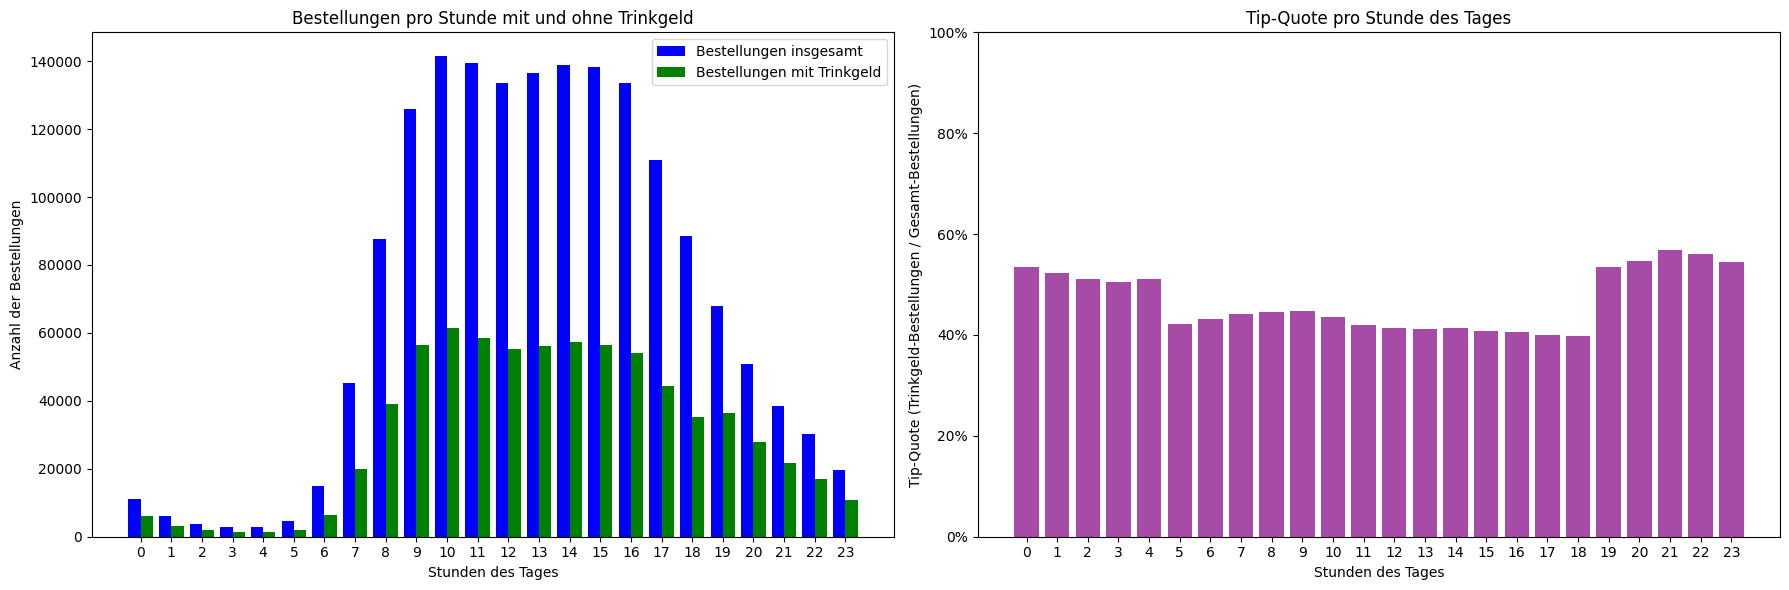

In [16]:
import matplotlib.pyplot as plt

# Daten für das erste Diagramm
hours = [row.hour_of_day for row in result_hours]
total_orders = [row.total_orders for row in result_hours]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_hours]

# Berechnung der Tip-Quote für das zweite Diagramm
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result_hours]

# Subplot erstellen: 1 Zeile, 2 Spalten
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # Angepasste Gesamtgröße

# Erster Plot: Bestellungen insgesamt und Bestellungen mit Trinkgeld
width = 0.4  # Breite der Balken
x = range(len(hours))

# Hinzufügen der Balken
ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='blue')
ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', color='green')

# Beschriftung des ersten Diagramms
ax1.set_xlabel('Stunden des Tages')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Stunde mit und ohne Trinkgeld')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(hours)
ax1.legend()

# Zweiter Plot: Tip-Quote pro Stunde des Tages
ax2.bar(hours, tip_ratios, color='purple', alpha=0.7)

# Beschriftung des zweiten Diagramms
ax2.set_xlabel('Stunden des Tages')
ax2.set_ylabel('Tip-Quote (Trinkgeld-Bestellungen / Gesamt-Bestellungen)')
ax2.set_title('Tip-Quote pro Stunde des Tages')

# Prozentuale Formatierung der Y-Achse (optional)
ax2.set_ylim(0, 1)  # Werte zwischen 0 und 1
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# X-Achsen-Beschriftung und Layout
ax2.set_xticks(hours)
ax2.set_xticklabels(hours)

# Diagramm anzeigen
plt.tight_layout()
plt.show()


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
from sqlalchemy import func


# Daten aus der Order-Tabelle extrahieren (inkl. Stunde des Tages)
result = session.query(
    Order.hour_of_day,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()


In [18]:
# Erstelle DataFrame
df = pd.DataFrame(result, columns=['hour_of_day', 'tips_given'])

# Umwandlung in kategoriale Variablen
df['hour_of_day'] = df['hour_of_day'].astype('category')

X = df[['hour_of_day']]  
y = df['tips_given']  

# Preprocessing mit OneHotEncoder für day_of_week und hour_of_day
preprocessor = ColumnTransformer(
    transformers=[
        ('hour_of_day', OneHotEncoder(), ['hour_of_day'])
    ]
)

# Aufteilen der Daten in Trainings- und Testdatensatz
X_train_hour, X_test_hour, y_train_hour, y_test_hour = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline erstellen
model_hour = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Vorverarbeitung
    ('classifier', LogisticRegression())  # Klassifikator
])

# Modell trainieren
model_hour.fit(X_train_hour, y_train_hour)

# Vorhersagen auf den Testdaten
y_pred_hour = model_hour.predict(X_test_hour)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test_hour, y_pred_hour)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zugriff auf Intercept und Koeffizienten
intercept = model_hour.named_steps['classifier'].intercept_[0]  # Der Intercept
coefficients = model_hour.named_steps['classifier'].coef_.flatten()  # Die Koeffizienten

# Wenn OneHotEncoder verwendet wird, benötigen wir die Feature-Namen, um sie den Koeffizienten zuzuordnen
# Dies ist besonders wichtig, da OneHotEncoding für die "day_of_week" und "hour_of_day"-Spalten zusätzliche Spalten erzeugt
# Holen der Spaltennamen des OneHotEncoders
ohe_feature_names = (
    model_hour.named_steps['preprocessor'].get_feature_names_out(input_features=['hour_of_day']).tolist()
)

# Erstelle DataFrame mit den Koeffizienten und den entsprechenden Feature-Namen
coeff_df = pd.DataFrame({
    'Feature': ohe_feature_names,
    'Coefficient': coefficients
})

# Ausgabe des Intercepts und der Koeffizienten
print("Intercept:", intercept)
display(coeff_df)


Accuracy: 57.65%
Intercept: -0.12848531701986954


,Feature,Coefficient
0,hour_of_day__hour_of_day_0,0.319291
1,hour_of_day__hour_of_day_1,0.221361
2,hour_of_day__hour_of_day_2,0.148062
3,hour_of_day__hour_of_day_3,0.103731
4,hour_of_day__hour_of_day_4,0.098312
5,hour_of_day__hour_of_day_5,-0.166472
6,hour_of_day__hour_of_day_6,-0.150764
7,hour_of_day__hour_of_day_7,-0.117070
8,hour_of_day__hour_of_day_8,-0.081748
9,hour_of_day__hour_of_day_9,-0.079419


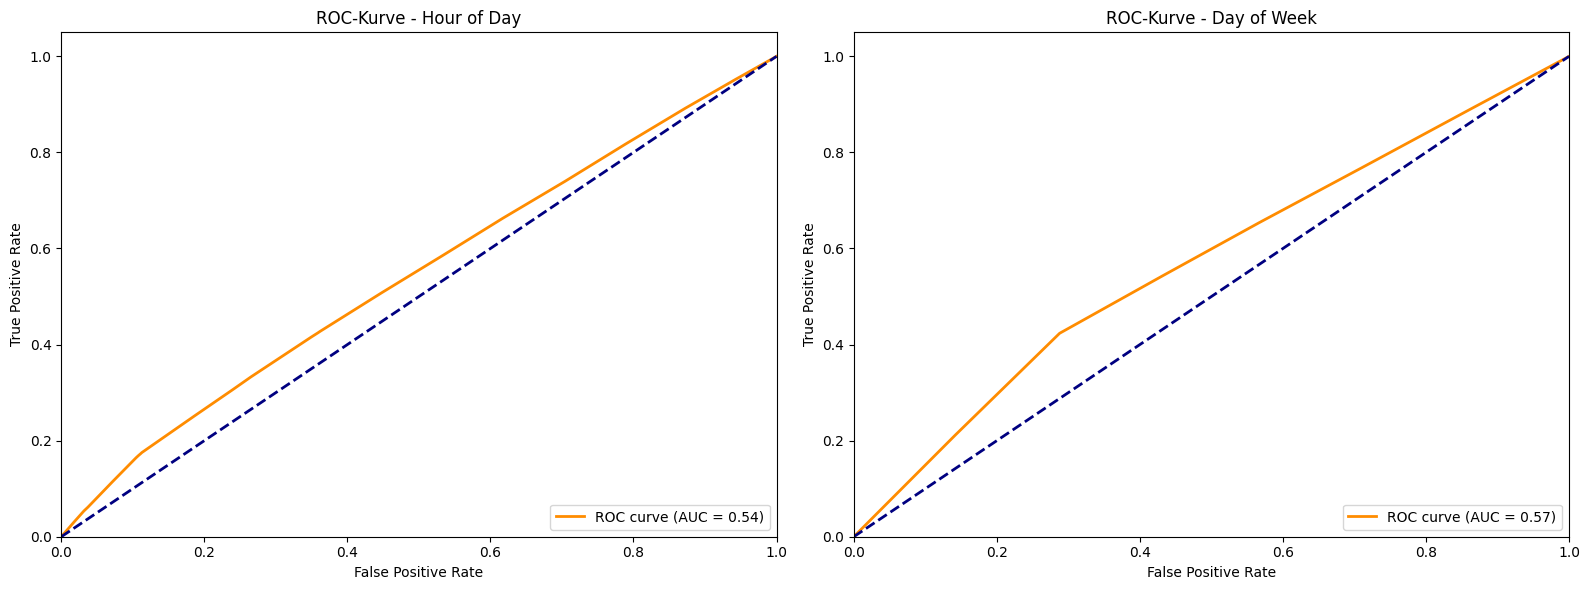

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Berechnung der Vorhersagewahrscheinlichkeiten für Stunde des Tages
y_prob_hour = model_hour.predict_proba(X_test_hour)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Stunde des Tages
fpr_hour, tpr_hour, _ = roc_curve(y_test_hour, y_prob_hour)
roc_auc_hour = auc(fpr_hour, tpr_hour)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_day, tpr_day, _ = roc_curve(y_test_day, y_prob_day)
roc_auc_day = auc(fpr_day, tpr_day)

# Erstelle Subplots für die beiden ROC-Kurven
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 Zeile, 2 Spalten

# Plot der ROC-Kurve für Stunde des Tages (links)
ax[0].plot(fpr_hour, tpr_hour, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_hour:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale Linie (Zufallsklassifikator)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC-Kurve - Hour of Day')
ax[0].legend(loc='lower right')

# Plot der ROC-Kurve für Wochentag (rechts)
ax[1].plot(fpr_day, tpr_day, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_day:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale Linie (Zufallsklassifikator)
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC-Kurve - Day of Week')
ax[1].legend(loc='lower right')

# Zeige die Plots
plt.tight_layout()  # Sorgt dafür, dass die Plots gut nebeneinander dargestellt werden
plt.show()


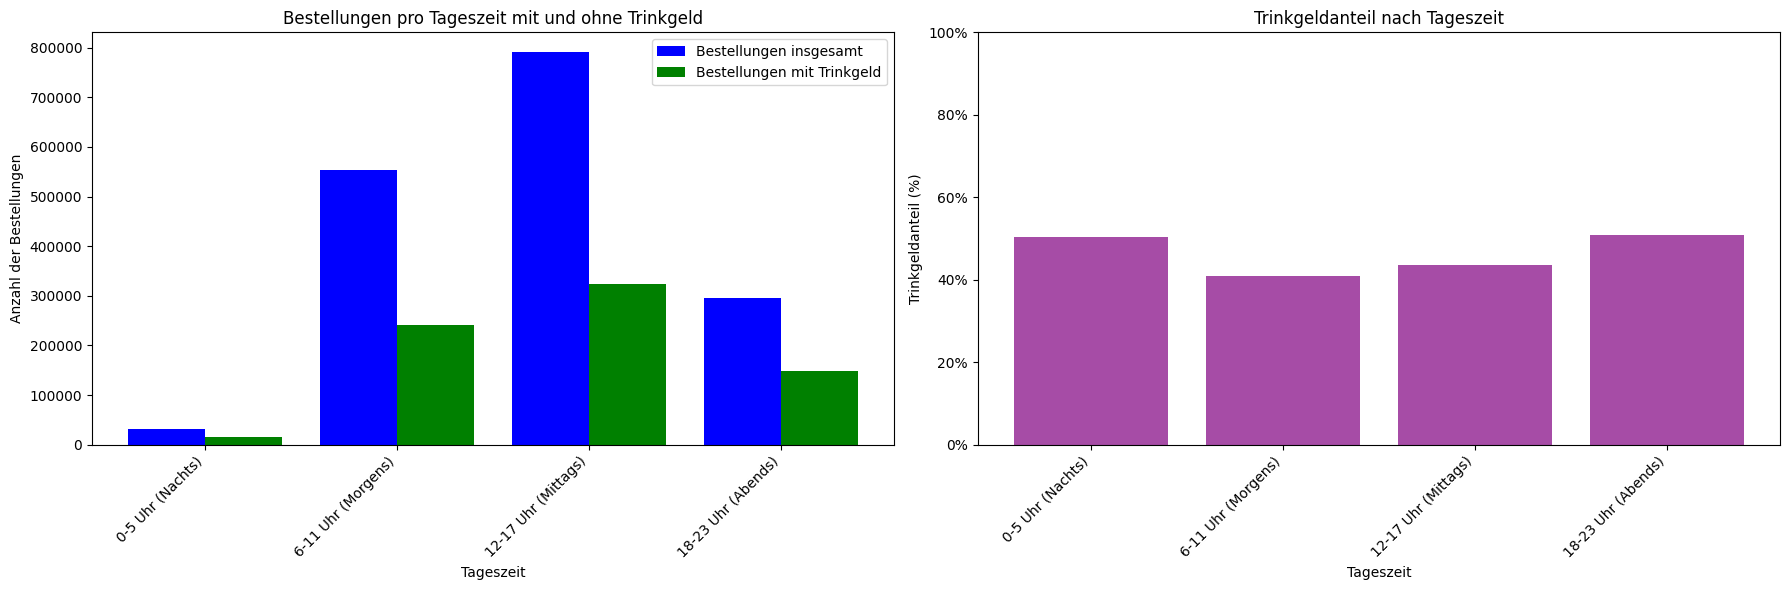

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

hours = [row.time_of_day for row in result_hours_grouped]
total_orders = [row.total_orders for row in result_hours_grouped]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_hours_grouped]

time_mapping = {
    "Nachts": "0-5 Uhr",
    "Morgens": "6-11 Uhr",
    "Mittags": "12-17 Uhr",
    "Abends": "18-23 Uhr"
}

desired_order = ["Nachts", "Morgens", "Mittags", "Abends"]
sorted_data = sorted(
    zip(hours, total_orders, total_tips),
    key=lambda x: desired_order.index(x[0])  
)

sorted_hours = [row[0] for row in sorted_data]
sorted_total_orders = [row[1] for row in sorted_data]
sorted_total_tips = [row[2] for row in sorted_data]

sorted_hours_with_time = [f"{time_mapping[hour]} ({hour})" for hour in sorted_hours]

tip_percentage = [row.tip_percentage for row in result_hours_grouped]
df = pd.DataFrame({
    'time_of_day': sorted_hours,
    'tip_percentage': tip_percentage
})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  

width = 0.4  
x = range(len(sorted_hours))

ax1.bar(x, sorted_total_orders, width, label='Bestellungen insgesamt', color='blue')
ax1.bar([i + width for i in x], sorted_total_tips, width, label='Bestellungen mit Trinkgeld', color='green')

ax1.set_xlabel('Tageszeit')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Tageszeit mit und ohne Trinkgeld')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(sorted_hours_with_time, rotation=45, ha='right')
ax1.legend()

ax2.bar(sorted_hours_with_time, df['tip_percentage'], color='purple', alpha=0.7)

ax2.set_xlabel('Tageszeit')
ax2.set_ylabel('Trinkgeldanteil (%)')
ax2.set_title('Trinkgeldanteil nach Tageszeit')

ax2.set_ylim(0, 1)  
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# X-Achsen-Beschriftungen anpassen
ax2.set_xticks(sorted_hours_with_time)
ax2.set_xticklabels(sorted_hours_with_time, rotation=45, ha='right')

# Layout und Anzeige
plt.tight_layout()
plt.show()


In [21]:
from scipy.stats import chi2_contingency
import pandas as pd
from tabulate import tabulate

# Ergebnisse der Query in ein DataFrame umwandeln
data = [
    {'hour_of_day': row[0], 'tips_given': row[1], 'no_tips': row[2]}
    for row in result_hours_tips
]
df = pd.DataFrame(data)

# Kontingenztabelle erstellen
contingency_table = df.set_index('hour_of_day')[['tips_given', 'no_tips']]

In [22]:
contingency_table

,tips_given,no_tips
hour_of_day,,
0,6003,5221
1,3244,2967
2,1931,1842
3,1397,1365
4,1406,1342
5,2005,2759
6,6462,8542
7,19897,25244
8,39013,48500


In [23]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = contingency_table.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
comparison_data_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(comparison_data_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
test_results_markdown = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(test_results_markdown))


Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                       6003 |                  4898.2  |                    5221 |               6325.8  |
|           1 |                       3244 |                  2710.51 |                    2967 |               3500.49 |
|           2 |                       1931 |                  1646.55 |                    1842 |               2126.45 |
|           3 |                       1397 |                  1205.35 |                    1365 |               1556.65 |
|           4 |                       1406 |                  1199.24 |                    1342 |               1548.76 |
|           5 |                       2005 |                  2079.03 |                    2759 |               2684.97 |
|           6 |                       6462 |                  6547.81 |                    8542 |               8456.19 |
|           7 |                      19897 |                 19699.7  |                   25244 |              25441.3  |
|           8 |                      39013 |                 38191    |                   48500 |              49322    |
|           9 |                      56300 |                 54945    |                   69604 |              70959    |
|          10 |                      61461 |                 61708    |                   79940 |              79693    |
|          11 |                      58575 |                 60887.1  |                   80945 |              78632.9  |
|          12 |                      55220 |                 58308.8  |                   78392 |              75303.2  |
|          13 |                      56133 |                 59601.9  |                   80442 |              76973.1  |
|          14 |                      57426 |                 60579.9  |                   81390 |              78236.1  |
|          15 |                      56499 |                 60345.5  |                   81780 |              77933.5  |
|          16 |                      54224 |                 58231.1  |                   79210 |              75202.9  |
|          17 |                      44257 |                 48367.5  |                   66575 |              62464.5  |
|          18 |                      35118 |                 38606    |                   53346 |              49858    |
|          19 |                      36331 |                 29631.4  |                   31568 |              38267.6  |
|          20 |                      27821 |                 22237    |                   23134 |              28718    |
|          21 |                      21782 |                 16750.1  |                   16600 |              21631.9  |
|          22 |                      16934 |                 13177.2  |                   13261 |              17017.8  |
|          23 |                      10674 |                  8559.19 |                    8939 |              11053.8  |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 14819.908 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 23        |
| Signifikanz           | Ja        |

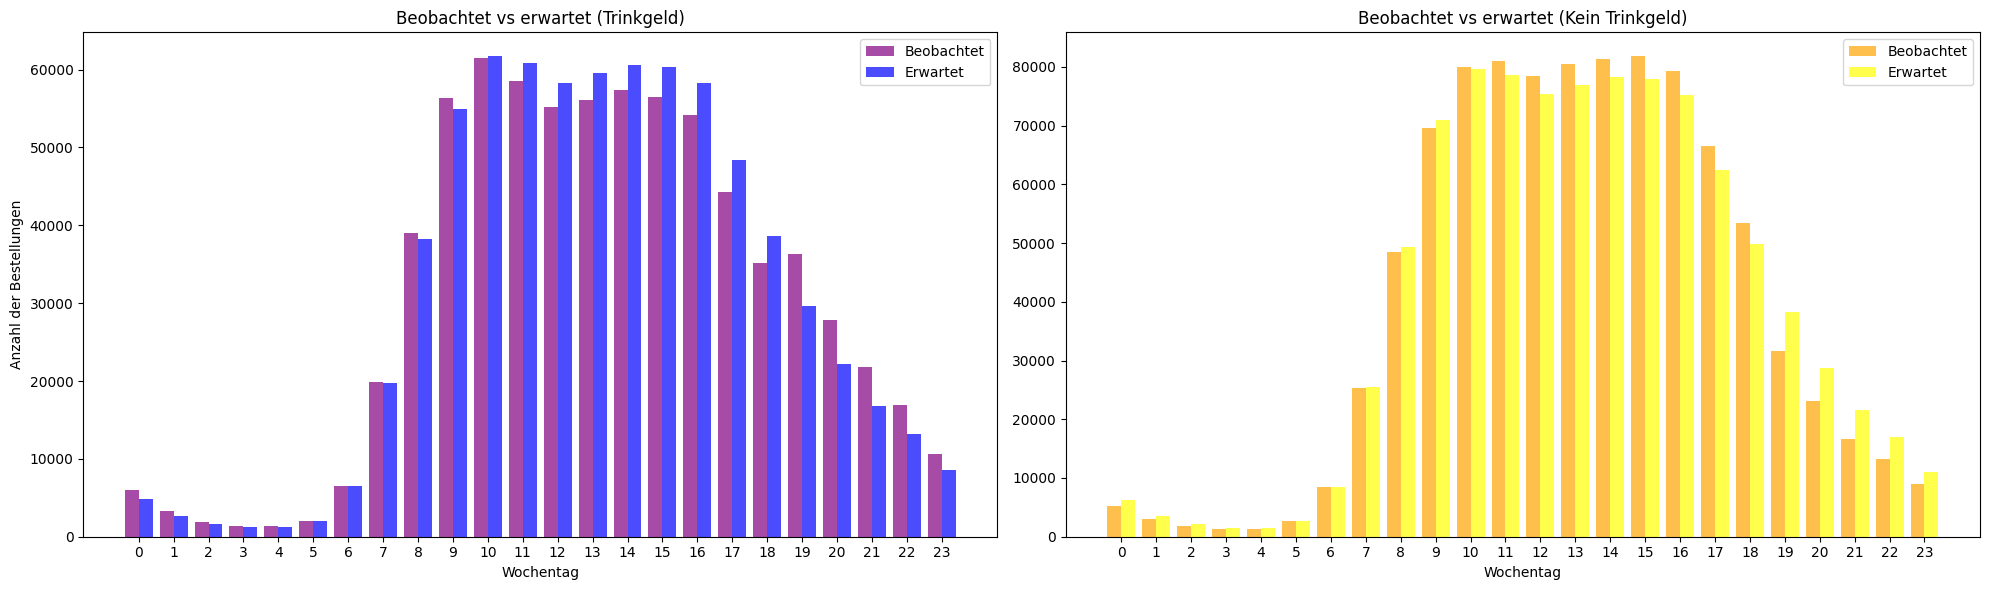

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Daten vorbereiten
observed = contingency_table.values  # Beobachtete Werte
days = contingency_table.index       # Wochentage
expected = expected                  # Erwartete Werte

# Balkenbreite und Positionen
bar_width = 0.4
x = np.arange(len(days))  # X-Positionen für Wochentage

# Subplots erstellen
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 Zeile, 2 Spalten

# Plot 1: Trinkgeld
axes[0].bar(x - bar_width / 2, observed[:, 0], bar_width, label="Beobachtet", color="purple", alpha=0.7)
axes[0].bar(x + bar_width / 2, expected[:, 0], bar_width, label="Erwartet", color="blue", alpha=0.7)
axes[0].set_title("Beobachtet vs erwartet (Trinkgeld)")
axes[0].set_xlabel("Wochentag")
axes[0].set_ylabel("Anzahl der Bestellungen")
axes[0].set_xticks(x)
axes[0].set_xticklabels(days)
axes[0].legend()

# Plot 2: Kein Trinkgeld
axes[1].bar(x - bar_width / 2, observed[:, 1], bar_width, label="Beobachtet", color="orange", alpha=0.7)
axes[1].bar(x + bar_width / 2, expected[:, 1], bar_width, label="Erwartet", color="yellow", alpha=0.7)
axes[1].set_title("Beobachtet vs erwartet (Kein Trinkgeld)")
axes[1].set_xlabel("Wochentag")
axes[1].set_xticks(x)
axes[1].set_xticklabels(days)
axes[1].legend()

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


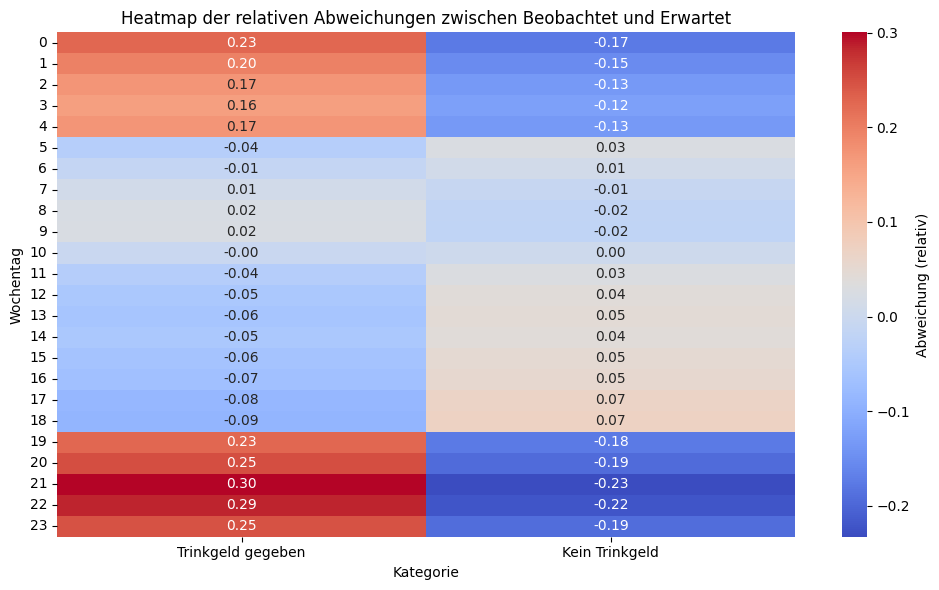

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Daten vorbereiten
observed = contingency_table.values  # Beobachtete Werte
expected = expected                  # Erwartete Werte
days = contingency_table.index       # Wochentage

# Abweichungen berechnen (relativ oder absolut)
deviation = (observed - expected) / expected  # Relative Abweichung (Prozentsatz)
# deviation = observed - expected  # Absolute Abweichung

# DataFrame für Heatmap erstellen
heatmap_data = pd.DataFrame(deviation, columns=["Trinkgeld gegeben", "Kein Trinkgeld"], index=days)

# Heatmap zeichnen
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Abweichung (relativ)'})
plt.title("Heatmap der relativen Abweichungen zwischen Beobachtet und Erwartet")
plt.xlabel("Kategorie")
plt.ylabel("Wochentag")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [26]:
---
## Heatmap Trinkgeldquote pro Wochentag und Stunde

SyntaxError: invalid syntax (3766731292.py, line 1)

In [29]:
from tabulate import tabulate

result_hours_days = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.hour_of_day, Order.day_of_the_week).all()

# Daten sammeln
data = []
for row in result_hours_days:
    tip_quote = row.total_tips / row.total_orders if row.total_orders else 0
    data.append([
        row.hour_of_day,
        row.total_orders,
        row.total_tips,
        f"{tip_quote:.2f}"  # Formatierte Trinkgeldquote
    ])

# Tabellenausgabe
headers = ["Stunde", "Bestellungen", "Trinkgeld-Bestellungen", "Trinkgeld-Quote"]
print(tabulate(data, headers=headers, tablefmt="grid"))


+----------+----------------+--------------------------+-------------------+
|   Stunde |   Bestellungen |   Trinkgeld-Bestellungen |   Trinkgeld-Quote |
+==========+================+==========================+===================+
|        0 |           1937 |                     1253 |              0.65 |
+----------+----------------+--------------------------+-------------------+
|        0 |           1813 |                     1123 |              0.62 |
+----------+----------------+--------------------------+-------------------+
|        0 |           1527 |                      733 |              0.48 |
+----------+----------------+--------------------------+-------------------+
|        0 |           1440 |                      697 |              0.48 |
+----------+----------------+--------------------------+-------------------+
|        0 |           1306 |                      648 |              0.5  |
+----------+----------------+--------------------------+-------------------+

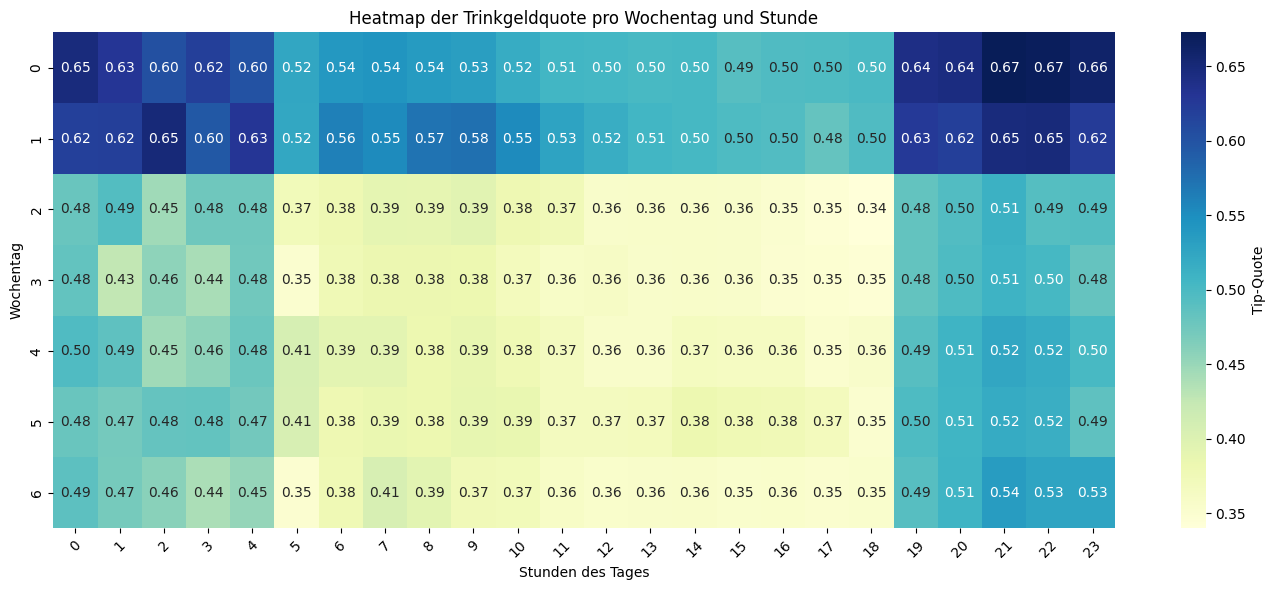

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Daten in ein DataFrame umwandeln
data = {
    'hour_of_day': [row.hour_of_day for row in result_hours_days],
    'day_of_the_week': [row.day_of_the_week for row in result_hours_days],  # Originale numerische Werte beibehalten
    'total_orders': [row.total_orders for row in result_hours_days],
    'total_tips': [row.total_tips if row.total_tips else 0 for row in result_hours_days],
}
df = pd.DataFrame(data)

# Zusätzliche Spalte für Tip-Quote berechnen
df['tip_ratio'] = df['total_tips'] / df['total_orders']

# Pivot-Tabelle erstellen (Stunden als Spalten, Wochentage als Zeilen)
heatmap_data = df.pivot(index='day_of_the_week', columns='hour_of_day', values='tip_ratio')

# Heatmap erstellen
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data,
    annot=True,       # Werte in den Zellen anzeigen
    fmt=".2f",        # Zahlenformat
    cmap='YlGnBu',    # Farbpalette
    cbar_kws={'label': 'Tip-Quote'},  # Farbskalenbeschriftung
    xticklabels=heatmap_data.columns,  # Stunden als X-Achsen-Beschriftung beibehalten
    yticklabels=heatmap_data.index  # Wochentage als Y-Achsen-Beschriftung beibehalten (numerische Werte)
)
plt.title('Heatmap der Trinkgeldquote pro Wochentag und Stunde')
plt.xlabel('Stunden des Tages')
plt.ylabel('Wochentag')
plt.xticks(rotation=45)  # Stunden leicht drehen für bessere Lesbarkeit
plt.tight_layout()  # Optimale Platznutzung
plt.show()


---
### Zusammenhang zwischen Trinkgeldverhalten und Abstand der vorherigen Bestellung

In [31]:
# Zähle die Anzahl der Bestellungen mit und ohne Trinkgeld basierend auf den Tagen seit der vorherigen Bestellung
result = session.query(
    Order.days_since_prior_order,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.days_since_prior_order).all()

result_test = session.query(
    Order.days_since_prior_order,
    Order.tips  # Hole die Trinkgelder direkt, ohne Aggregation
).all()



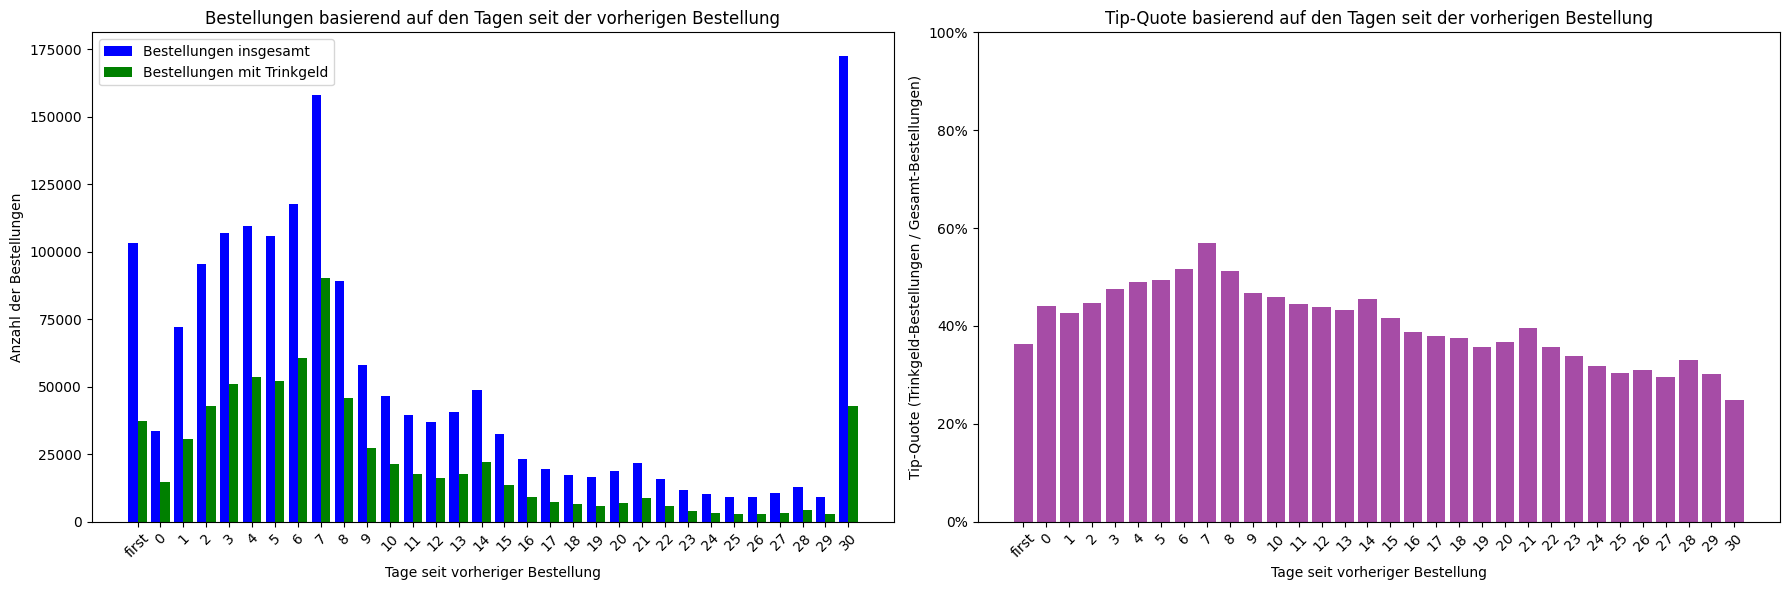

In [32]:
import matplotlib.pyplot as plt

# Daten bereinigen
days_since_prior = [
    "first" if row.days_since_prior_order is None else str(int(row.days_since_prior_order))
    for row in result
]
total_orders = [row.total_orders for row in result]
total_tips = [row.total_tips if row.total_tips else 0 for row in result]
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result]

# Subplot erstellen: 1 Zeile, 2 Spalten
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # Breite von 18 für nebeneinander

# Diagramm 1: Bestellungen insgesamt und mit Trinkgeld
width = 0.4
x = range(len(days_since_prior))

ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='blue')
ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', color='green')

ax1.set_xlabel('Tage seit vorheriger Bestellung')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen basierend auf den Tagen seit der vorherigen Bestellung')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(days_since_prior, rotation=45)
ax1.legend()

# Diagramm 2: Tip-Quote
ax2.bar(range(len(days_since_prior)), tip_ratios, color='purple', alpha=0.7)

ax2.set_xlabel('Tage seit vorheriger Bestellung')
ax2.set_ylabel('Tip-Quote (Trinkgeld-Bestellungen / Gesamt-Bestellungen)')
ax2.set_title('Tip-Quote basierend auf den Tagen seit der vorherigen Bestellung')

# Prozentuale Formatierung der Y-Achse
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

ax2.set_xticks(range(len(days_since_prior)))
ax2.set_xticklabels(days_since_prior, rotation=45)

# Layout und Anzeige
plt.tight_layout()  # Optimale Platznutzung
plt.show()


In [33]:
import pandas as pd

# Ergebnis in DataFrame umwandeln
data = {
    "days_since_prior_order": [
        "first" if row.days_since_prior_order is None else int(row.days_since_prior_order)
        for row in result_test
    ],
    "tip_status": [
        "with_tip" if row.tips else "without_tip" for row in result_test
    ],
}

df = pd.DataFrame(data)

# Kreuztabelle erstellen
crosstab = pd.crosstab(
    index=df["days_since_prior_order"],  # Zeilen: Tage seit vorheriger Bestellung
    columns=df["tip_status"],            # Spalten: Mit oder ohne Trinkgeld
).fillna(0)

crosstab


tip_status,with_tip,without_tip
days_since_prior_order,,
0,14802,18805
1,30763,41479
2,42740,52721
3,50836,56292
4,53617,55926
5,52129,53574
6,60690,57054
7,90158,68047
8,45741,43606


In [50]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(crosstab)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = crosstab.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
camparsion_data_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(comparison_data_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
test_results_markdown = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(test_results_markdown))



Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                       6003 |                  4898.2  |                    5221 |               6325.8  |
|           1 |                       3244 |                  2710.51 |                    2967 |               3500.49 |
|           2 |                       1931 |                  1646.55 |                    1842 |               2126.45 |
|           3 |                       1397 |                  1205.35 |                    1365 |               1556.65 |
|           4 |                       1406 |                  1199.24 |                    1342 |               1548.76 |
|           5 |                       2005 |                  2079.03 |                    2759 |               2684.97 |
|           6 |                       6462 |                  6547.81 |                    8542 |               8456.19 |
|           7 |                      19897 |                 19699.7  |                   25244 |              25441.3  |
|           8 |                      39013 |                 38191    |                   48500 |              49322    |
|           9 |                      56300 |                 54945    |                   69604 |              70959    |
|          10 |                      61461 |                 61708    |                   79940 |              79693    |
|          11 |                      58575 |                 60887.1  |                   80945 |              78632.9  |
|          12 |                      55220 |                 58308.8  |                   78392 |              75303.2  |
|          13 |                      56133 |                 59601.9  |                   80442 |              76973.1  |
|          14 |                      57426 |                 60579.9  |                   81390 |              78236.1  |
|          15 |                      56499 |                 60345.5  |                   81780 |              77933.5  |
|          16 |                      54224 |                 58231.1  |                   79210 |              75202.9  |
|          17 |                      44257 |                 48367.5  |                   66575 |              62464.5  |
|          18 |                      35118 |                 38606    |                   53346 |              49858    |
|          19 |                      36331 |                 29631.4  |                   31568 |              38267.6  |
|          20 |                      27821 |                 22237    |                   23134 |              28718    |
|          21 |                      21782 |                 16750.1  |                   16600 |              21631.9  |
|          22 |                      16934 |                 13177.2  |                   13261 |              17017.8  |
|          23 |                      10674 |                  8559.19 |                    8939 |              11053.8  |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 53883.206 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 31        |
| Signifikanz           | Ja        |

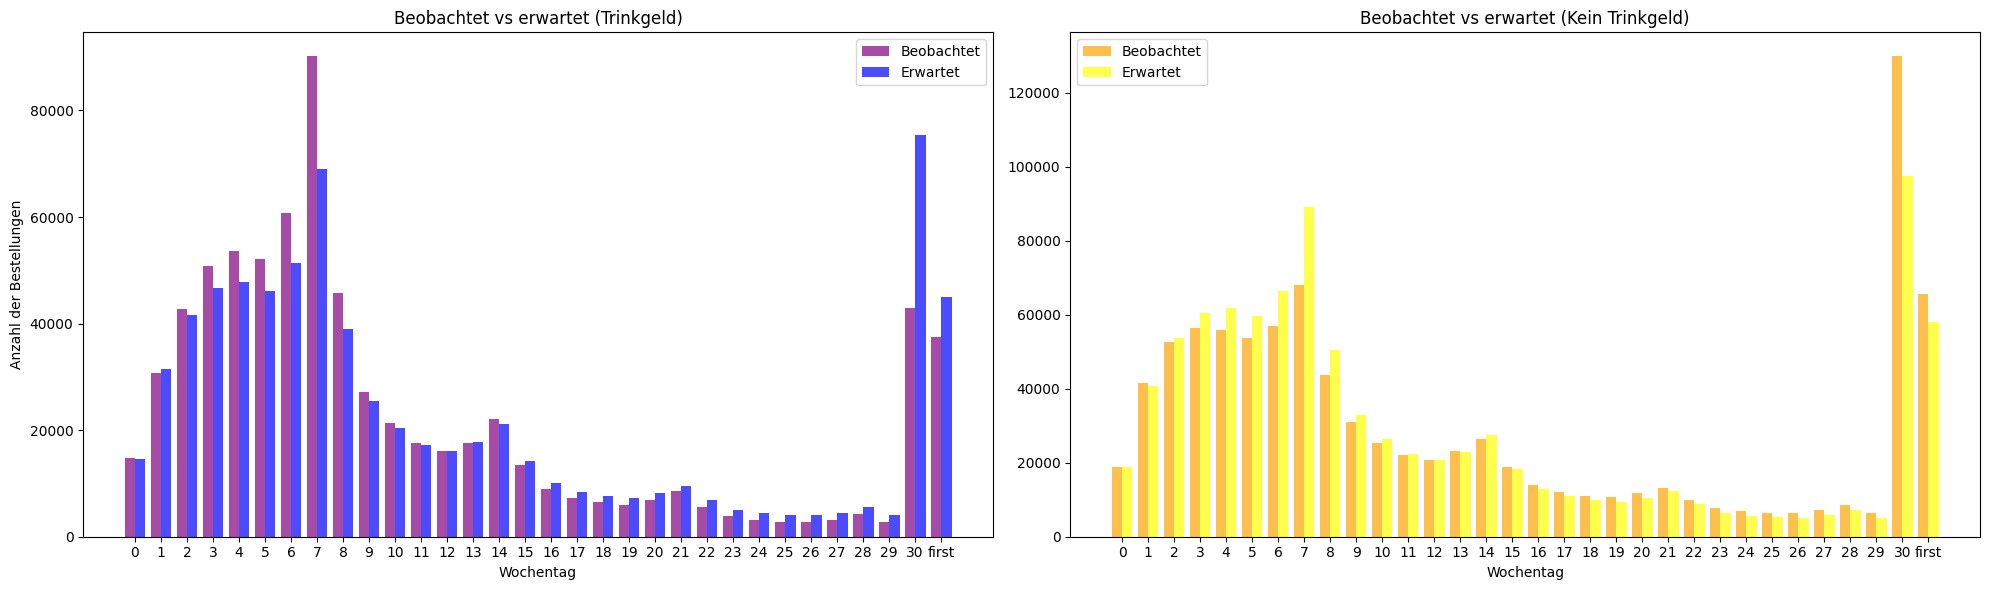

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Daten vorbereiten
observed = crosstab.values  # Beobachtete Werte
days = crosstab.index       # Wochentage
expected = expected                  # Erwartete Werte

# Balkenbreite und Positionen
bar_width = 0.4
x = np.arange(len(days))  # X-Positionen für Wochentage

# Subplots erstellen
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 Zeile, 2 Spalten

# Plot 1: Trinkgeld
axes[0].bar(x - bar_width / 2, observed[:, 0], bar_width, label="Beobachtet", color="purple", alpha=0.7)
axes[0].bar(x + bar_width / 2, expected[:, 0], bar_width, label="Erwartet", color="blue", alpha=0.7)
axes[0].set_title("Beobachtet vs erwartet (Trinkgeld)")
axes[0].set_xlabel("Wochentag")
axes[0].set_ylabel("Anzahl der Bestellungen")
axes[0].set_xticks(x)
axes[0].set_xticklabels(days)
axes[0].legend()

# Plot 2: Kein Trinkgeld
axes[1].bar(x - bar_width / 2, observed[:, 1], bar_width, label="Beobachtet", color="orange", alpha=0.7)
axes[1].bar(x + bar_width / 2, expected[:, 1], bar_width, label="Erwartet", color="yellow", alpha=0.7)
axes[1].set_title("Beobachtet vs erwartet (Kein Trinkgeld)")
axes[1].set_xlabel("Wochentag")
axes[1].set_xticks(x)
axes[1].set_xticklabels(days)
axes[1].legend()

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


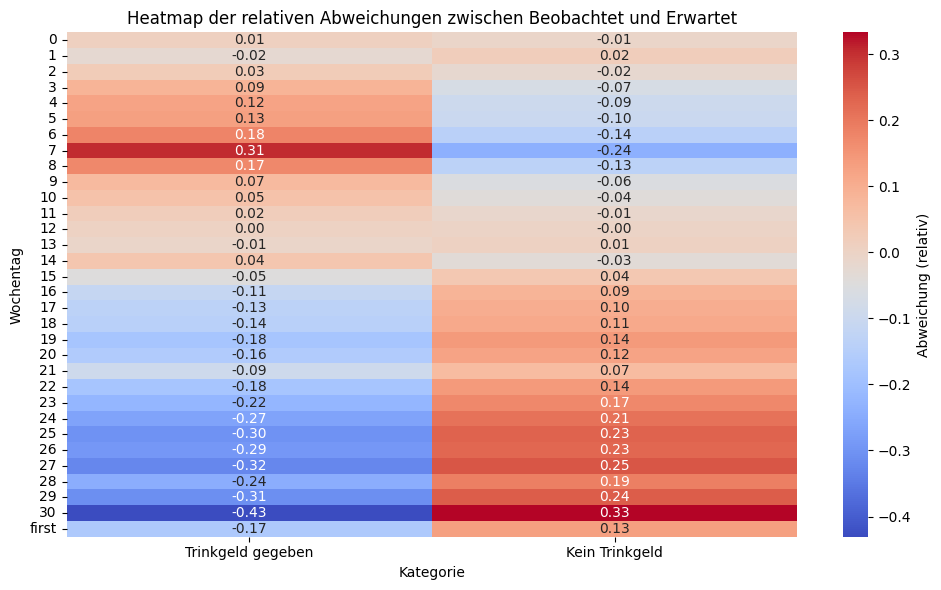

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Daten vorbereiten
observed = crosstab.values  # Beobachtete Werte
expected = expected                  # Erwartete Werte
days = crosstab.index       # Wochentage

# Abweichungen berechnen (relativ oder absolut)
deviation = (observed - expected) / expected  # Relative Abweichung (Prozentsatz)
# deviation = observed - expected  # Absolute Abweichung

# DataFrame für Heatmap erstellen
heatmap_data = pd.DataFrame(deviation, columns=["Trinkgeld gegeben", "Kein Trinkgeld"], index=days)

# Heatmap zeichnen
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Abweichung (relativ)'})
plt.title("Heatmap der relativen Abweichungen zwischen Beobachtet und Erwartet")
plt.xlabel("Kategorie")
plt.ylabel("Wochentag")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


---
#### Logistische Regression mit alles Zeitangaben als Feature

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
from sqlalchemy import func


# Daten aus der Order-Tabelle extrahieren (inkl. Stunde des Tages)
result = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    Order.days_since_prior_order,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

In [38]:
# Erstelle DataFrame
df = pd.DataFrame(result, columns=['hour_of_day', 'day_of_the_week', 'days_since_prior_order', 'tips_given'])

# Umwandlung in kategoriale Variablen
df['hour_of_day'] = df['hour_of_day'].astype('category')
df['day_of_the_week'] = df['day_of_the_week'].astype('category')
df['days_since_prior_order'] = df['days_since_prior_order'].astype('category')

X = df[['hour_of_day', 'day_of_the_week', 'days_since_prior_order']]  
y = df['tips_given']  

# Preprocessing mit OneHotEncoder für day_of_week und hour_of_day
preprocessor = ColumnTransformer(
    transformers=[
        ('hour_of_day', OneHotEncoder(), ['hour_of_day', 'day_of_the_week', 'days_since_prior_order'])
    ]
)

# Aufteilen der Daten in Trainings- und Testdatensatz
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline erstellen
model_all = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Vorverarbeitung
    ('classifier', LogisticRegression())  # Klassifikator
])

# Modell trainieren
model_all.fit(X_train_all, y_train_all)

# Vorhersagen auf den Testdaten
y_pred_all = model_all.predict(X_test_all)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test_all, y_pred_all)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zugriff auf Intercept und Koeffizienten
intercept = model_all.named_steps['classifier'].intercept_[0]  # Der Intercept
coefficients = model_all.named_steps['classifier'].coef_.flatten()  # Die Koeffizienten

# Wenn OneHotEncoder verwendet wird, benötigen wir die Feature-Namen, um sie den Koeffizienten zuzuordnen
# Dies ist besonders wichtig, da OneHotEncoding für die "day_of_week" und "hour_of_day"-Spalten zusätzliche Spalten erzeugt
# Holen der Spaltennamen des OneHotEncoders
ohe_feature_names = (
    model_all.named_steps['preprocessor'].get_feature_names_out(input_features=['hour_of_day', 'day_of_the_week', 'days_since_prior_order']).tolist()
)

# Erstelle DataFrame mit den Koeffizienten und den entsprechenden Feature-Namen
coeff_df = pd.DataFrame({
    'Feature': ohe_feature_names,
    'Coefficient': coefficients
})

# Ausgabe des Intercepts und der Koeffizienten
print("Intercept:", intercept)
display(coeff_df)

Accuracy: 61.46%
Intercept: -0.2577138480810668


,Feature,Coefficient
0,hour_of_day__hour_of_day_0,0.328639
1,hour_of_day__hour_of_day_1,0.231733
2,hour_of_day__hour_of_day_2,0.151920
3,hour_of_day__hour_of_day_3,0.107983
4,hour_of_day__hour_of_day_4,0.114304
...,...,...
58,hour_of_day__days_since_prior_order_27.0,-0.479697
59,hour_of_day__days_since_prior_order_28.0,-0.369656
60,hour_of_day__days_since_prior_order_29.0,-0.486733
61,hour_of_day__days_since_prior_order_30.0,-0.726265


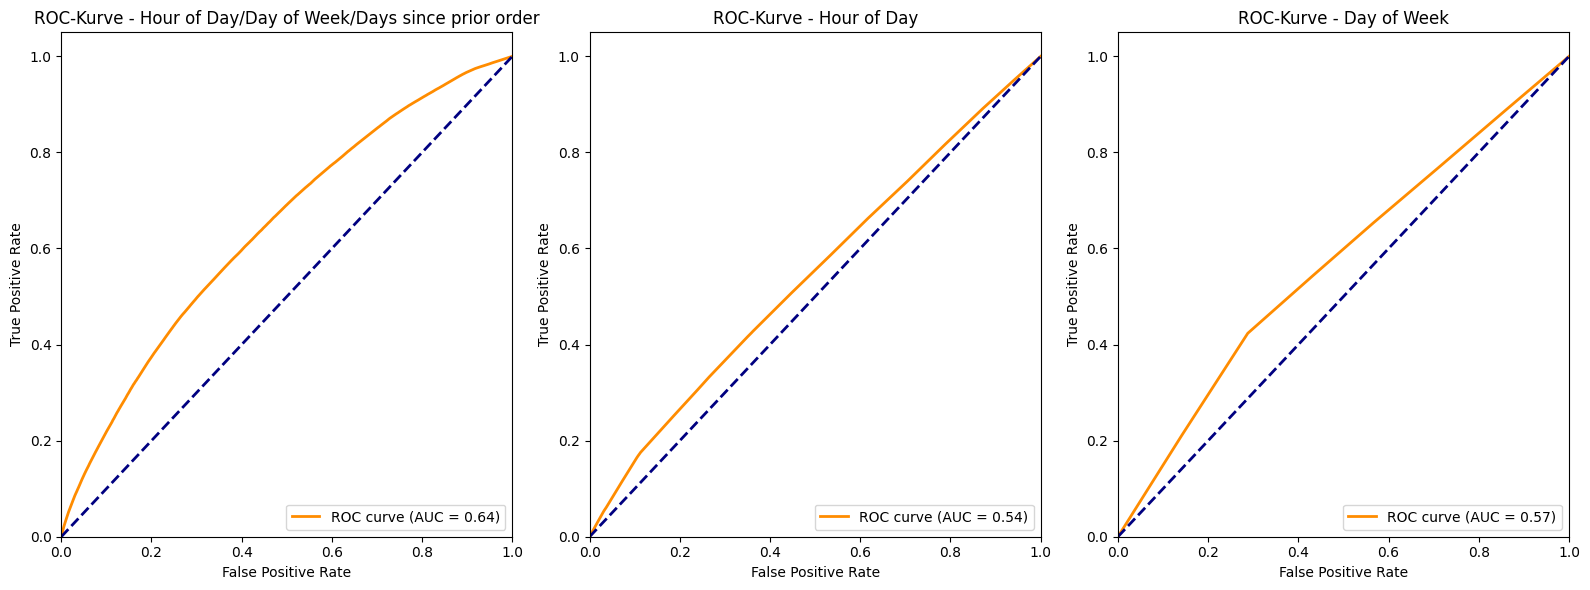

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Berechnung der Vorhersagewahrscheinlichkeiten für Stunde des Tages
y_prob_hour = model_hour.predict_proba(X_test_hour)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Stunde des Tages
fpr_hour, tpr_hour, _ = roc_curve(y_test_hour, y_prob_hour)
roc_auc_hour = auc(fpr_hour, tpr_hour)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_day, tpr_day, _ = roc_curve(y_test_day, y_prob_day)
roc_auc_day = auc(fpr_day, tpr_day)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_all = model_all.predict_proba(X_test_all)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_all, tpr_all, _ = roc_curve(y_test_all, y_prob_all)
roc_auc_all = auc(fpr_all, tpr_all)
# Erstelle Subplots für die beiden ROC-Kurven
fig, ax = plt.subplots(1, 3, figsize=(16, 6))  # 1 Zeile, 2 Spalten

# Plot der ROC-Kurve für Alle Features
ax[0].plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_all:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale Linie (Zufallsklassifikator)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC-Kurve - Hour of Day/Day of Week/Days since prior order')
ax[0].legend(loc='lower right')

# Plot der ROC-Kurve für Stunde des Tages (links)
ax[1].plot(fpr_hour, tpr_hour, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_hour:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale Linie (Zufallsklassifikator)
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC-Kurve - Hour of Day')
ax[1].legend(loc='lower right')

# Plot der ROC-Kurve für Wochentag (rechts)
ax[2].plot(fpr_day, tpr_day, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_day:.2f})')
ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale Linie (Zufallsklassifikator)
ax[2].set_xlim([0.0, 1.0])
ax[2].set_ylim([0.0, 1.05])
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')
ax[2].set_title('ROC-Kurve - Day of Week')
ax[2].legend(loc='lower right')

# Zeige die Plots
plt.tight_layout()  # Sorgt dafür, dass die Plots gut nebeneinander dargestellt werden
plt.show()
